Estudio de Prophet

In [1]:
import pandas as pd
import numpy as np
from prophet import Prophet
import matplotlib.pyplot as plt


dfVentas = pd.read_csv('ventas.csv')
dfVentas.head()

Importing plotly failed. Interactive plots will not work.


,Cantidad (en UM de inventario),VentaNeta,CodCliente,Número de documento,ItemCode,CodVendedor,Código de almacén de línea,Fecha,Descripción del artículo,CanalDeVenta,Kilombos
0,30,58172.0,C77196968,1054011,100401405101,11,B30,5-Apr-21,Almendra Cubierta Con Chocolate Bitter Bl 200Gr.,Televenta,6.0
1,60,116345.0,C76047944,1065766,100401405101,4,B30,11-Aug-21,Almendra Cubierta Con Chocolate Bitter Bl 200Gr.,Televenta,12.0
2,60,116344.0,C76047944,1071927,100401405101,4,B30,20-Oct-21,Almendra Cubierta Con Chocolate Bitter Bl 200Gr.,Televenta,12.0
3,60,116345.0,T00000581,1044987,100401405101,38,B30,3-Nov-20,Almendra Cubierta Con Chocolate Bitter Bl 200Gr.,Televenta,12.0
4,60,116345.0,T00000377,1055172,100401405101,38,B30,21-Apr-21,Almendra Cubierta Con Chocolate Bitter Bl 200Gr.,Televenta,12.0


In [2]:
cranberriesItems = [140201405101, 140202405101, 140101110103, 140101110104, 140201408102, 140201409102, 140202408102, 140202409101, 140203409101]
cranberriesDf = dfVentas[dfVentas['ItemCode'].isin(cranberriesItems)]

In [3]:
cranberriesDf['Descripción del artículo'].value_counts()

Cranberry Entero  Cubierta Chocolate Bitter Bl. 5Kg       1318
Cranberry Cubierta Chocolate Leche Bl. 5Kg                 657
Cranberry Entero  Cubierta Chocolate Bitter Bl.200 Gr.     105
Cranberry Cubierta Chocolate Leche Bl. 200 Gr.              74
Cranberry Entero  Cubierta Chocolate Bitter Bl. 1Kg          1
Name: Descripción del artículo, dtype: int64

In [3]:
columns_hash = {
    'Cantidad (en UM de inventario)': 'cantidad',
    'VentaNeta': 'venta_total',
    'CodCliente': 'cod_cliente',
    'Número de documento': 'n_boleta',
    'ItemCode': 'item_code',
    'CodVendedor': 'cod_vendedor',
    'Código de almacén de línea': 'cod_almacen',
    'Fecha': 'fecha',
    'Descripción del artículo': 'descripcion',
    'CanalDeVenta': 'canal_venta',
    'Kilombos': 'kilombos',
}
# Renombrar las columnas
cranberriesDf = cranberriesDf.rename(columns=columns_hash)
cranberriesDf.head(5)

,cantidad,venta_total,cod_cliente,n_boleta,item_code,cod_vendedor,cod_almacen,fecha,descripcion,canal_venta,kilombos
1988,30,51677.98322,C76825371,1055564,140202405101,4,B30,27-Apr-21,Cranberry Cubierta Chocolate Leche Bl. 200 Gr.,Televenta,6.0
1989,30,51618.00000,C76047944,1042002,140202405101,4,B30,11-Sep-20,Cranberry Cubierta Chocolate Leche Bl. 200 Gr.,Televenta,6.0
1990,30,51618.00000,C76047944,1044398,140202405101,4,B30,23-Oct-20,Cranberry Cubierta Chocolate Leche Bl. 200 Gr.,Televenta,6.0
1991,30,51618.00000,C76047944,1045289,140202405101,4,B30,6-Nov-20,Cranberry Cubierta Chocolate Leche Bl. 200 Gr.,Televenta,6.0
1992,30,51618.00000,C76116617,1051111,140202405101,4,B30,11-Feb-21,Cranberry Cubierta Chocolate Leche Bl. 200 Gr.,Televenta,6.0


In [4]:
# Eliminamos los datos que sean kilombos negativos
cranberriesDf = cranberriesDf[cranberriesDf['kilombos'] > 0]

In [5]:
# Formateamos la fecha
cranberriesDf['ds'] = cranberriesDf['fecha'].apply(lambda date: pd.to_datetime(date, format='%d-%b-%y')).sort_values(ascending=True)
cranberriesDf['ds-monthYear'] = cranberriesDf['ds'].dt.strftime('%Y-%m')
cranberriesDf['ds-weekYear'] = cranberriesDf['ds'].dt.strftime('%Y-%U')

In [150]:
# Eliminamos las columnas que no nos interesan
groupedDaily = cranberriesDf.groupby('ds').agg({'kilombos': ['sum', 'max', 'min', 'mean', 'median'], 'cod_cliente': 'nunique', 'cod_vendedor': 'nunique'})
groupedMonthly = cranberriesDf.groupby('ds-monthYear').agg({'kilombos': ['sum', 'max', 'min', 'mean', 'median'], 'cod_cliente': 'nunique', 'cod_vendedor': 'nunique'})
groupedWeekly = cranberriesDf.groupby('ds-weekYear').agg({'kilombos': ['sum', 'max', 'min', 'mean', 'median'], 'cod_cliente': 'nunique', 'cod_vendedor': 'nunique'})

In [151]:
groupedDaily.columns = ['_'.join(col).strip() for col in groupedDaily.columns.values]
groupedMonthly.columns = ['_'.join(col).strip() for col in groupedMonthly.columns.values]
groupedWeekly.columns = ['_'.join(col).strip() for col in groupedWeekly.columns.values]

In [152]:
groupedDaily.index

DatetimeIndex(['2019-04-02', '2019-04-05', '2019-04-30', '2019-05-02',
               '2019-05-03', '2019-05-06', '2019-05-07', '2019-05-09',
               '2019-05-10', '2019-05-13',
               ...
               '2021-11-19', '2021-11-22', '2021-11-23', '2021-11-24',
               '2021-11-25', '2021-11-26', '2021-11-29', '2021-11-30',
               '2021-12-01', '2021-12-02'],
              dtype='datetime64[ns]', name='ds', length=471, freq=None)

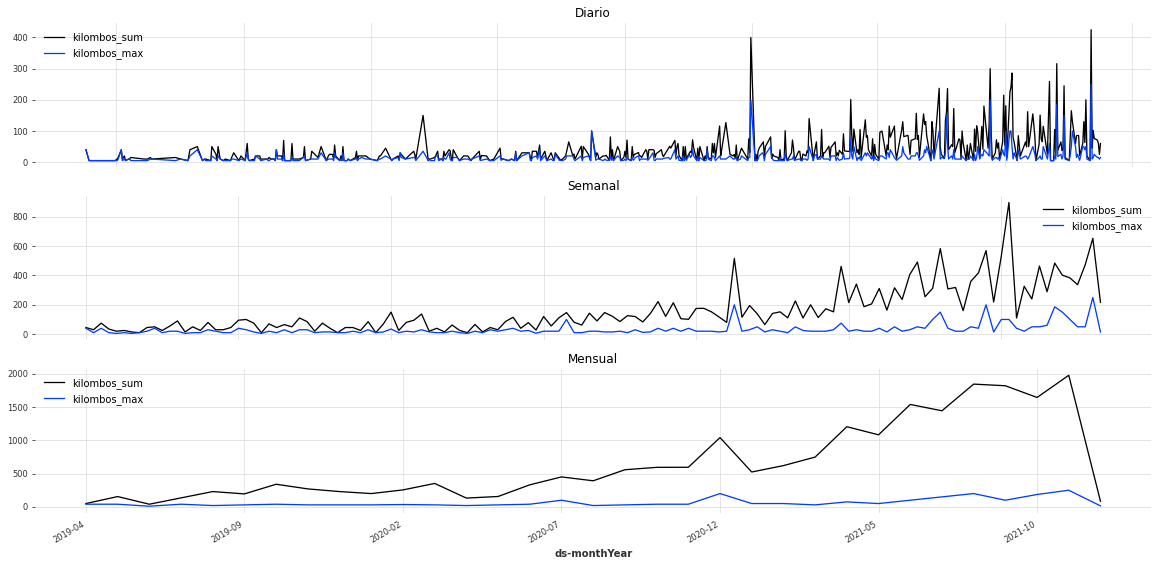

In [153]:
def plot_grouped(grouped, title, ax, cols=['kilombos_sum', 'kilombos_max', 'kilombos_min', 'kilombos_mean', 'kilombos_median']):
    for col in cols:
        grouped.plot(y=col, ax=ax)
    ax.set_title(title)

fig, ax = plt.subplots(3, 1, figsize=(20, 10))
plot_grouped(groupedDaily, 'Diario', ax[0], ['kilombos_sum', 'kilombos_max'])
plot_grouped(groupedWeekly, 'Semanal', ax[1], ['kilombos_sum', 'kilombos_max'])
plot_grouped(groupedMonthly, 'Mensual', ax[2], ['kilombos_sum', 'kilombos_max'])
fig.autofmt_xdate()

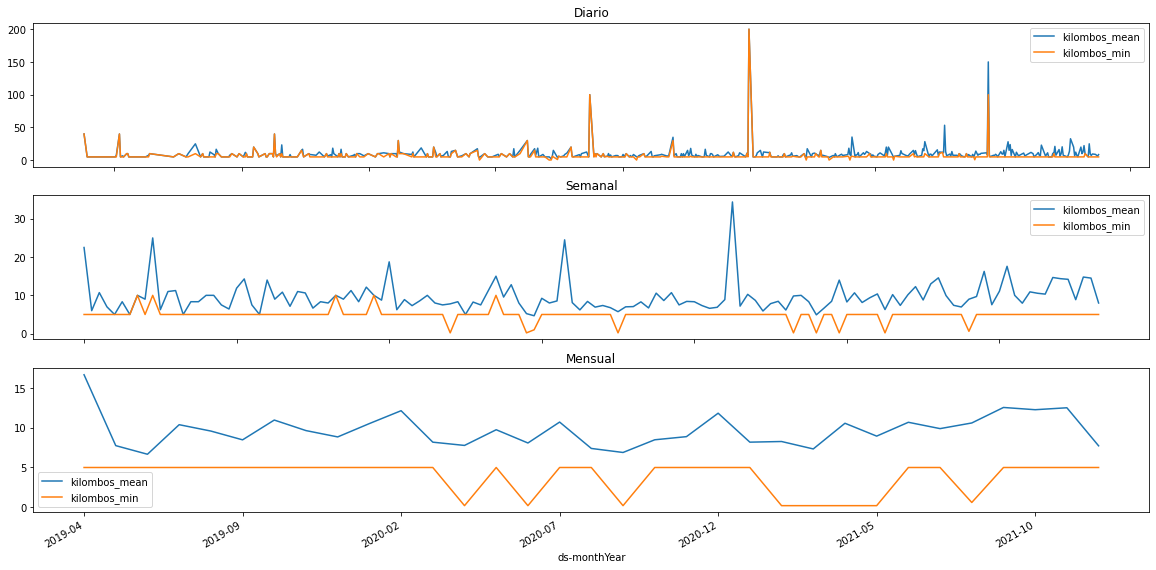

In [11]:
fig, ax = plt.subplots(3, 1, figsize=(20, 10))
plot_grouped(groupedDaily, 'Diario', ax[0], ['kilombos_mean', 'kilombos_min'])
plot_grouped(groupedWeekly, 'Semanal', ax[1], ['kilombos_mean', 'kilombos_min'])
plot_grouped(groupedMonthly, 'Mensual', ax[2], ['kilombos_mean', 'kilombos_min'])
fig.autofmt_xdate()

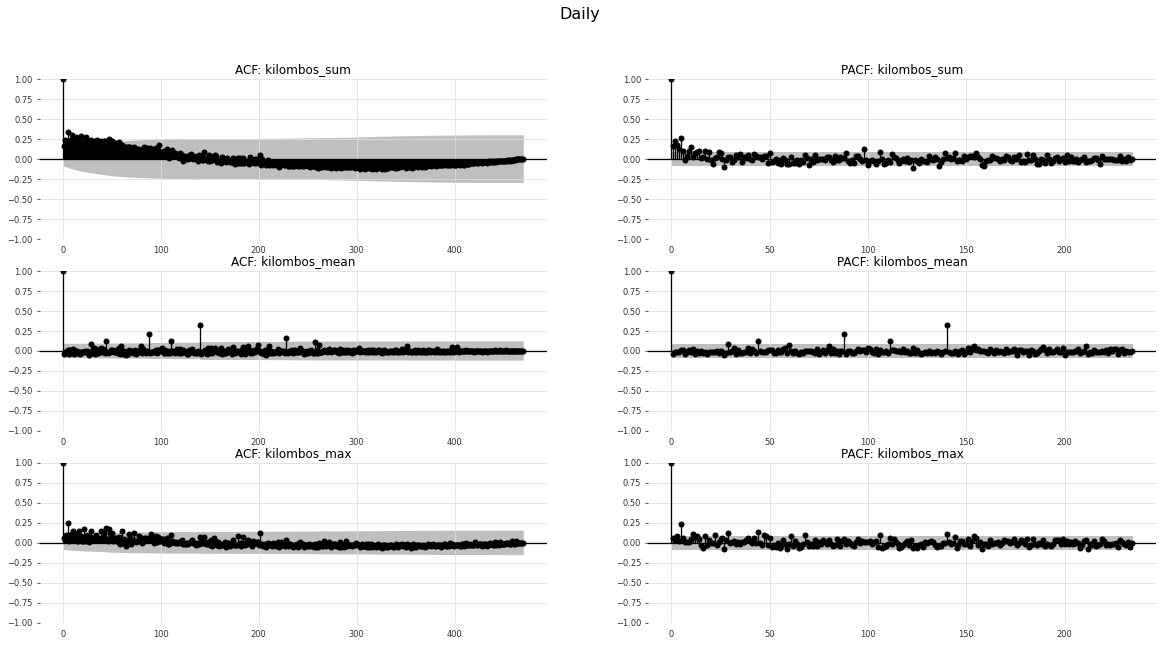

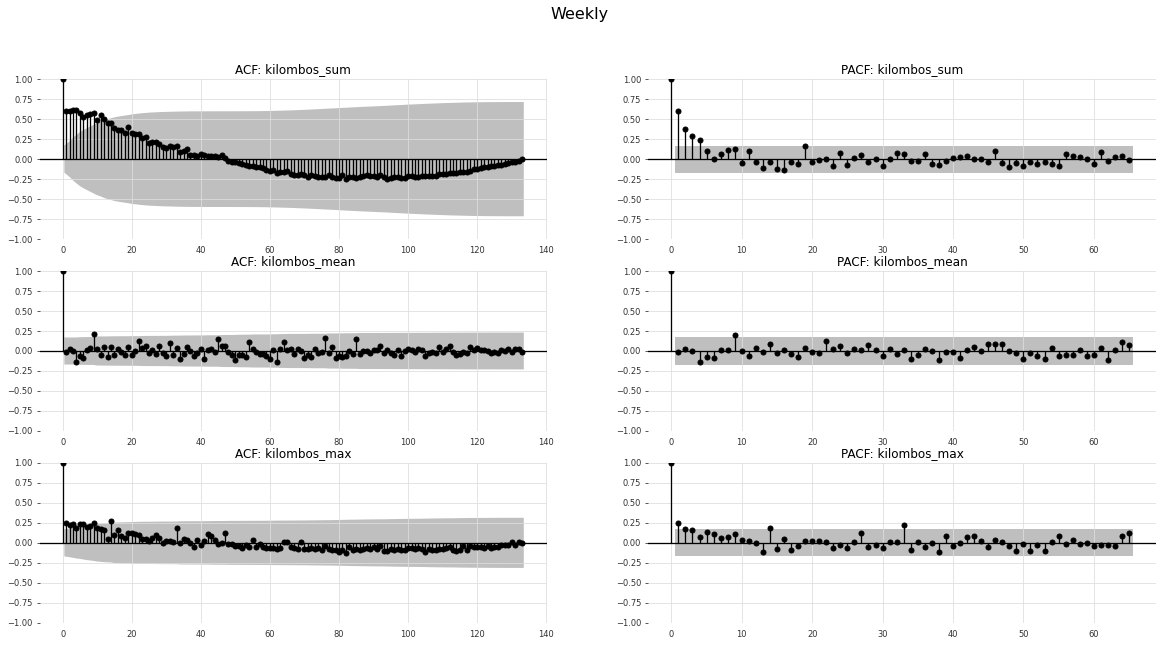

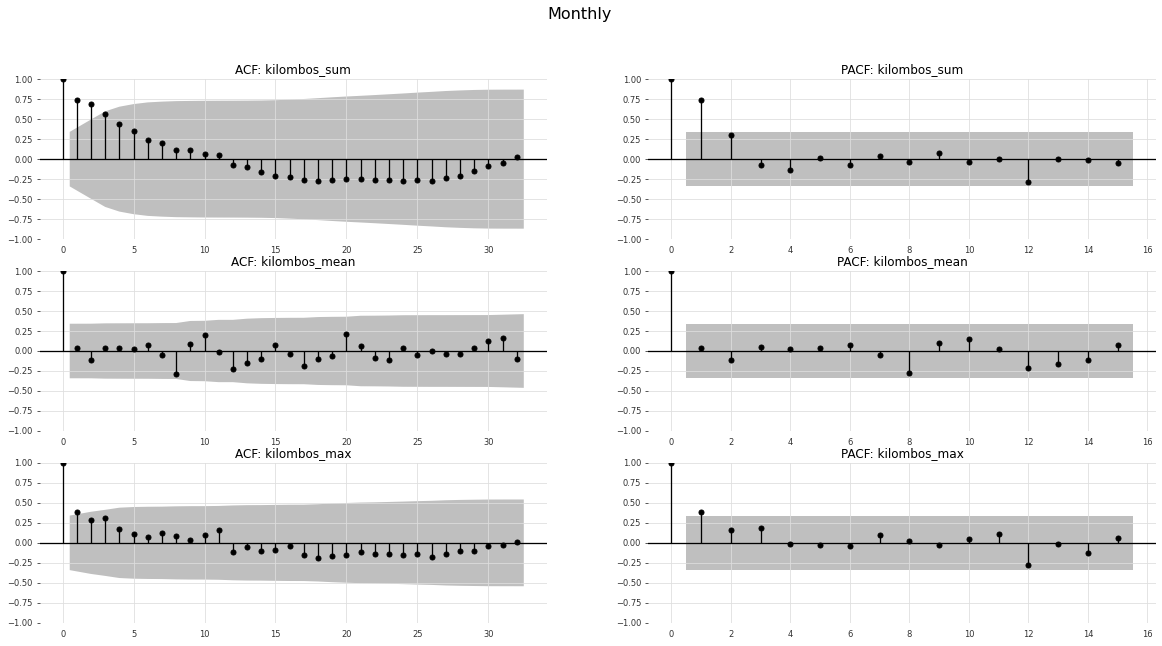

In [20]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import math

def plot_correlations(df, columns, title):
    fig, ax = plt.subplots(len(columns), 2, figsize=(20, 10))
    fig.suptitle(title, fontsize=16)
    for i, column in enumerate(columns):
        lag = df[column].shape[0] - 1 
        plot_acf(df[column], lags=lag, ax=ax[i, 0])
        ax[i, 0].set_title('ACF: ' + column)
        plot_pacf(df[column], lags=math.floor(lag/2) - 1 , ax=ax[i, 1], method='ywm')
        ax[i, 1].set_title('PACF: ' + column)

plot_correlations(groupedDaily, ['kilombos_sum', 'kilombos_mean', 'kilombos_max'], 'Daily')
plot_correlations(groupedWeekly, ['kilombos_sum', 'kilombos_mean', 'kilombos_max'], 'Weekly')
plot_correlations(groupedMonthly, ['kilombos_sum', 'kilombos_mean', 'kilombos_max'], 'Monthly')

D:\Anaconda\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
D:\Anaconda\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
D:\Anaconda\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


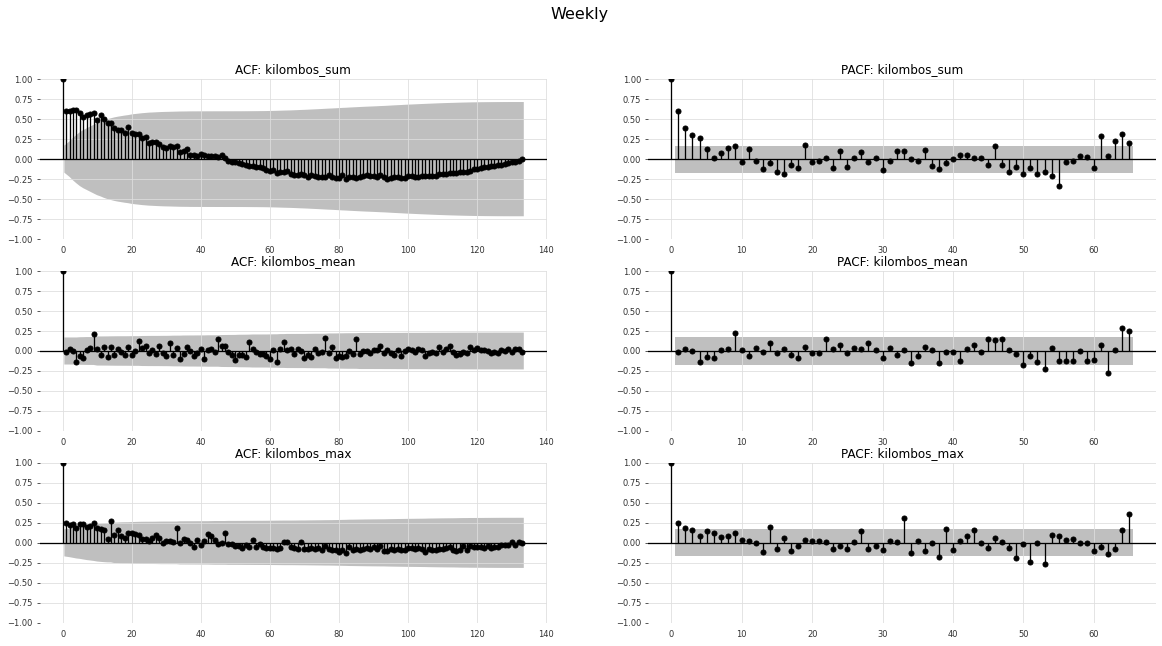

In [19]:
import datetime
filteredDf = cranberriesDf[cranberriesDf['ds'] < datetime.datetime(2022, 12, 1)].groupby('ds-weekYear').agg({'kilombos': ['sum', 'max', 'min', 'mean'], 'cod_cliente': 'nunique', 'cod_vendedor': 'nunique'})
filteredDf.columns = ['_'.join(col).strip() for col in filteredDf.columns.values]
plot_correlations(filteredDf, ['kilombos_sum', 'kilombos_mean', 'kilombos_max'], 'Weekly')

In [27]:
groupedWeekly.index

Index(['2019-13', '2019-17', '2019-18', '2019-19', '2019-21', '2019-22',
       '2019-25', '2019-26', '2019-27', '2019-28',
       ...
       '2021-39', '2021-40', '2021-41', '2021-42', '2021-43', '2021-44',
       '2021-45', '2021-46', '2021-47', '2021-48'],
      dtype='object', name='ds-weekYear', length=134)

In [8]:
# Transformamos las fechas de cada semana a pd.Int64Index
# Desde 2019-13 a 2021-48 hay 134 semanas
año = 2019
semana = 13
index = 1
indexes = []

while True:
    cero = '0' if semana < 10 else ''
    label = f'{año}-{cero}{semana}'
    if label in groupedWeekly.index:
        indexes.append(index)
    if label == '2021-48':
        break
    index += 1
    semana += 1
    if semana == 53:
        semana = 1
        año += 1
# Creamos un nuevo DataFrame con las fechas de las semanas
print(len(indexes))
newIndex = pd.Int64Index(indexes)
intWeekly = groupedWeekly
intWeekly.index = newIndex


134


In [9]:
intWeekly.head(5)

,kilombos_sum,kilombos_max,kilombos_min,kilombos_mean,cod_cliente_nunique,cod_vendedor_nunique
1,45.0,40.0,5.0,22.500000,2,1
5,30.0,10.0,5.0,6.000000,5,3
6,75.0,40.0,5.0,10.714286,6,3
7,35.0,10.0,5.0,7.000000,4,2
9,20.0,5.0,5.0,5.000000,3,2


In [12]:
from darts import TimeSeries
from darts.models.forecasting.arima import ARIMA


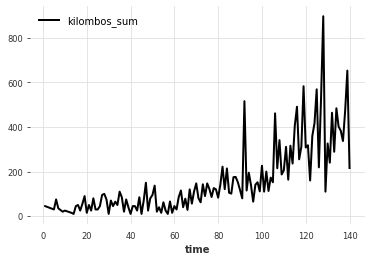

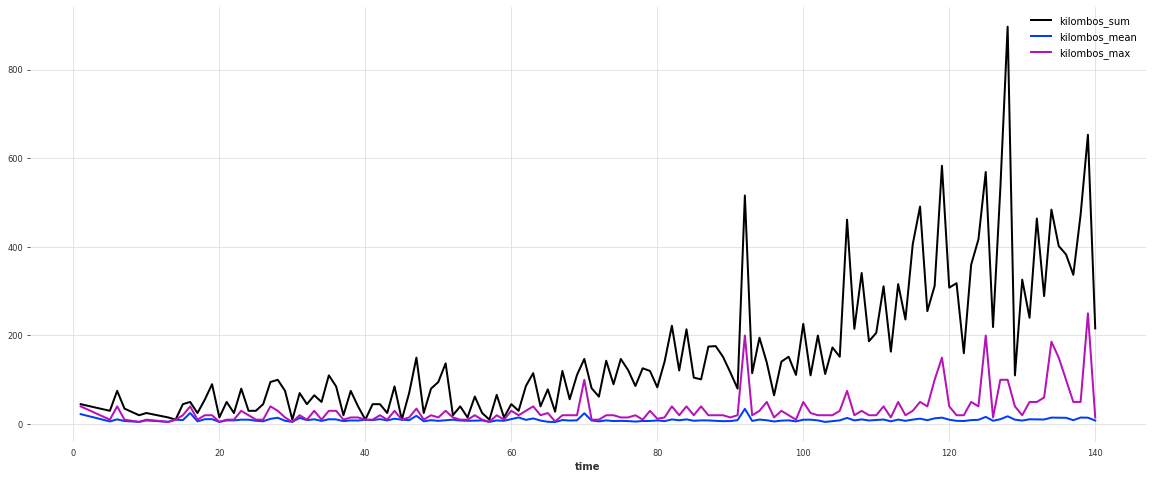

In [34]:
# Creamos una instancia de TimeSeries
series = TimeSeries.from_dataframe(intWeekly, None, value_cols=['kilombos_sum', 'kilombos_mean', 'kilombos_max'], freq='W')
# La graficamos
plt.figure(figsize=(20, 8))
series.plot()

In [41]:
def getSeparationIndex(df, frac=0.8):
    separationIndex = int(len(df.index) * frac)
    return df.index[separationIndex]

# Separamos los datos en train y test
train, test = series.split_before(getSeparationIndex(intWeekly))

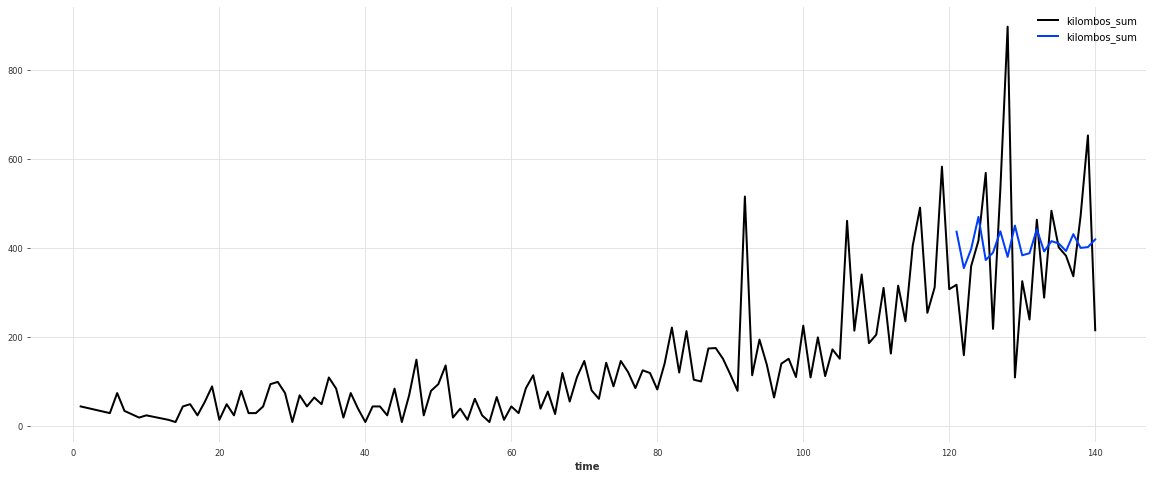

In [143]:
# Creamos una instancia de ARIMA
arima = ARIMA()
# Ajustamos el modelo
arima.fit(train['kilombos_sum'])
# Predecimos
predictions = arima.predict(len(test))
# Graficamos
plt.figure(figsize=(20, 8))
series['kilombos_sum'].plot()
predictions.plot()



In [81]:

train.pd_dataframe().tail()

component,kilombos_sum,kilombos_mean,kilombos_max
time,,,
116,491.0,12.275000,50.0
117,255.0,8.793103,40.0
118,312.0,13.000000,100.0
119,583.0,14.575000,150.0
120,308.0,9.935484,40.0


In [144]:
s = getSeparationIndex(train.pd_dataframe())
pre_train, pre_test = train.split_before(s)

In [147]:
best_model, params = arima.gridsearch({
    'p': np.arange(4,18,1, dtype=int),
    'q': np.arange(2,8,1, dtype=int),
}, pre_train['kilombos_sum'], val_series=pre_test['kilombos_sum'], verbose=False, n_jobs=-1)

[2022-02-14 19:23:15,597] INFO | darts.models.forecasting.forecasting_model | Chosen parameters: {'p': 17, 'q': 7}
[2022-02-14 19:23:15,597] INFO | darts.models.forecasting.forecasting_model | Chosen parameters: {'p': 17, 'q': 7}


D:\Anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\Anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\Anaconda\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


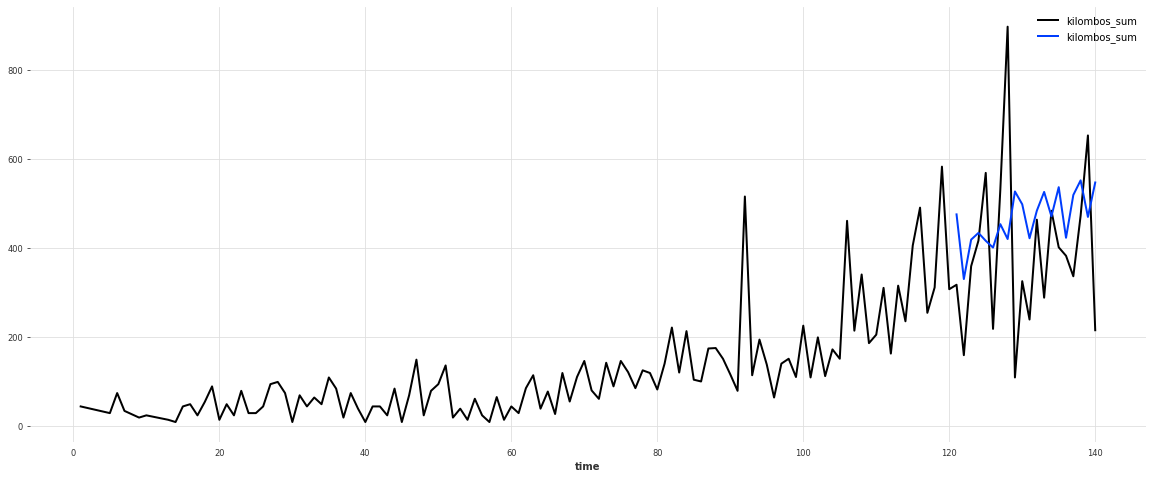

In [149]:
# Predecimos
best_model.fit(train['kilombos_sum'])
predictions = best_model.predict(len(test))
# Graficamos
plt.figure(figsize=(20, 8))
series['kilombos_sum'].plot()
predictions.plot()

In [125]:
train.with_columns_renamed(['kilombos_mean', 'kilombos_max'], ['kilombos_mean', 'kilombos_max']).describe()

component,kilombos_sum,kilombos_mean,kilombos_max
count,114.000000,114.000000,114.000000
mean,117.419298,9.369469,25.552632
std,110.500451,4.163203,25.860446
min,10.000000,4.666667,5.000000
25%,45.000000,7.217548,10.000000
50%,85.500000,8.372549,20.000000
75%,147.000000,10.182661,30.000000
max,583.000000,34.400000,200.000000


[2022-02-14 19:21:34,974] INFO | darts.models.forecasting.forecasting_model | Chosen parameters: {'lags': 19}
[2022-02-14 19:21:34,974] INFO | darts.models.forecasting.forecasting_model | Chosen parameters: {'lags': 19}


{'lags': 19}


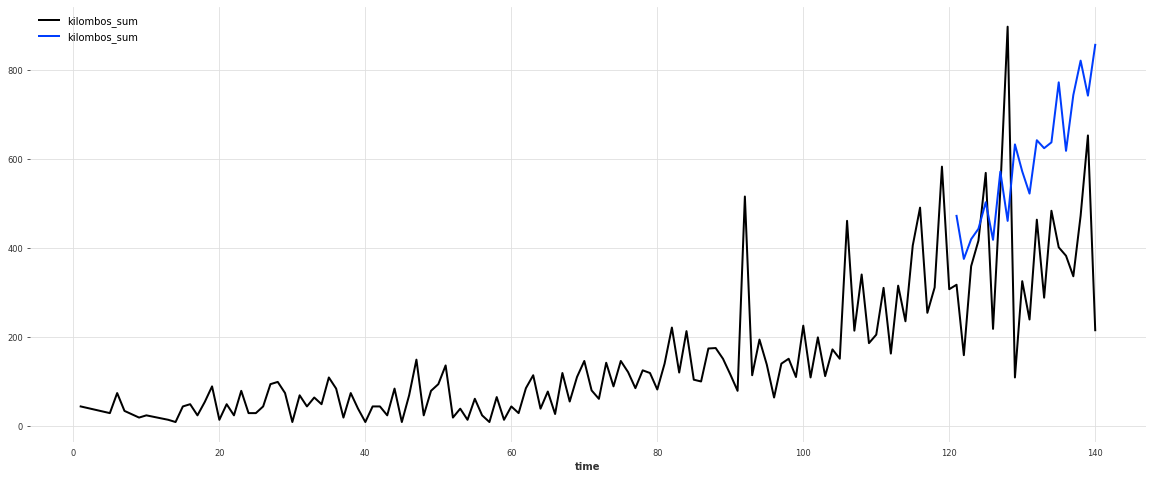

In [142]:
from darts.models.forecasting.regression_model import RegressionModel

# Creamos una instancia de RegressionModel
regression = RegressionModel(lags=1)
# Ajustamos el modelo
best_model, params = regression.gridsearch({
    'lags': [int(i + 1) for i in range(30)],
}, pre_train['kilombos_sum'], val_series=pre_test['kilombos_sum'], verbose=False, n_jobs=-1)
print(params)
best_model.fit(train['kilombos_sum'])
# Predecimos
predictions = best_model.predict(len(test))
# Graficamos
plt.figure(figsize=(20, 8))
series['kilombos_sum'].plot()
predictions.plot()


In [16]:
prophetDf = groupedDaily.reset_index().rename(columns={'kilombos_sum': 'y'}).drop(columns=['cod_cliente_nunique', 'cod_vendedor_nunique'])
# prophetDf['cap'] = 150
m = Prophet().add_country_holidays(country_name='CL')
m.fit(prophetDf)


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


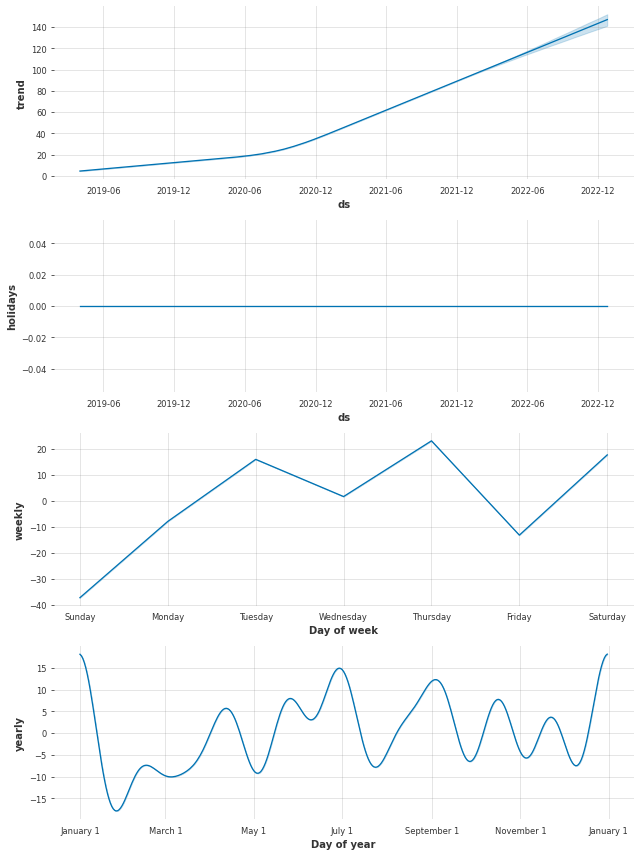

In [17]:
future = m.make_future_dataframe(periods=56, freq='W')
# future['cap'] = 300
forecast = m.predict(future)
fig1 = m.plot_components(forecast)
